In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.segmentation import clear_border, find_boundaries
from scipy.ndimage import binary_fill_holes 
from skimage.measure import label
from skimage.util import crop


the size of template image is:  3509 2484 3


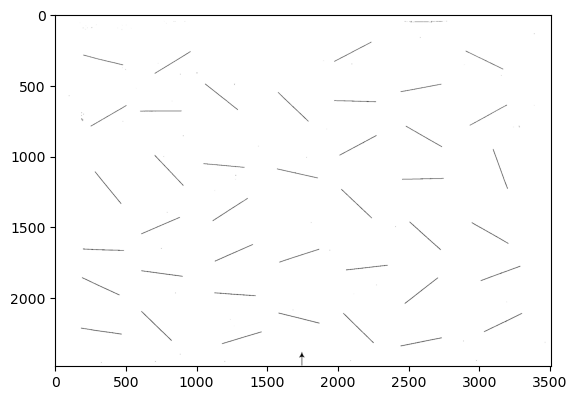

In [3]:
input_dir = "input_images"
output_dir = "resized_images"
# read the template image. we use this to resize all images based on its size
template_img = cv2.imread(os.path.join(input_dir, "template.png"))
tmp_height,tmp_width, channels = template_img.shape
print("the size of template image is: ", tmp_width, tmp_height, channels)
plt.imshow(template_img)

In [ ]:
# read all images in the input directory, resize them same as the template image, register them to the template image
tmp_img_size = (tmp_width, tmp_height)
isExist = os.path.isdir(output_dir)
if not isExist:
    os.mkdir(output_dir)
    print('Folder to store resized images did not exist.. creating now')
# for each file, resize the image and save it in the resized_images folder
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)
    file_dir_exist = os.path.isfile(os.path.join(output_dir, filename))

    if filename.endswith(".png") and  not os.path.isfile(output_path):
        img = cv2.imread(os.path.join(input_dir, filename))
        img_resized = cv2.resize(img, tmp_img_size)
        cv2.imwrite(os.path.join(output_dir, filename), img_resized)
        print(f'Resized and saved: {filename}')
    else:
        print(f'Skipped (already exists): {filename}')


In [7]:

def img_register_translation(template_img, input_img):
    # Convert to grayscale
    template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
    input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    # Use phase correlation to estimate translation shift
    shift = cv2.phaseCorrelate(np.float32(template_gray), np.float32(input_gray))
    dx, dy = shift[0]

    # Build translation matrix
    M = np.float32([[1, 0, -dx], [0, 1, -dy]])

    # Apply translation to original image
    aligned_img = cv2.warpAffine(
        input_img,
        M,
        (template_img.shape[1], template_img.shape[0]),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(255, 255, 255)
    )

    return aligned_img, template_gray, input_gray

In [ ]:
# dir for resized images
# output_dir :resized_images
registered_dir = 'registered_image'
isExist = os.path.isdir(registered_dir)
if not isExist:
    os.mkdir(registered_dir)
    print('Folder to store registered images did not exist.. creating now')

# for each file, register the image to template and save it in the registered_images folder
for filename in os.listdir(output_dir):
    file_dir_exist = os.path.isfile(os.path.join(registered_dir, filename))
    if filename.endswith('.png') and not file_dir_exist:
        print('Processing image registration for filename: ', filename)
        img_input = cv2.imread(os.path.join(output_dir, filename))
        (aligned_img,template_gray,input_gray) = img_register_translation(template_img, img_input)

                # Skip if registration failed
        if aligned_img is None:
            print(f"Registration failed for {filename}. Skipping.")
            continue
            
        plt.figure(figsize = (10,10))
        plt.imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
        plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB), alpha=0.3)
        plt.title(f'Overlay: {filename}')
        plt.axis('off')
        plt.show()

        cv2.imwrite(os.path.join(registered_dir, filename), aligned_img)
        print(f" Registered and saved: {filename}")
    else:
        print(f'Skipped (already exists or not a PNG): {filename}')
        
       
